## Catalyst - So many Faces

First of all, let's install the requirements, download the dataset, and import all python dependencies.


### Requirements 
Today we would use Catalyst and Albumentations libraries.
*\
[Catalyst](https://github.com/catalyst-team/catalyst) is the PyTorch framework for Deep Learning research and development. It focuses on reproducibility, rapid experimentation, and codebase reuse so you can create something new rather than write another regular train loop.*


### Dataset 
For the tutorial purpose, we would use [imagewoof2](https://catalyst-team.github.io/catalyst/api/contrib.html#catalyst.contrib.datasets.cv.imagewoof.Imagewoof) classification dataset.
*\
Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. Source: [fastai/imagenette](https://github.com/fastai/imagenette#imagewoof).*


### Imports
We need to import all the required PyTorch dependencies and all Catalyst supported Faces implementations for our benchmark tutorial.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pipenv shell

Launching subshell in virtual environment...
/content#  . /root/.local/share/virtualenvs/content-cQIIIOO2/bin/activate
(content) /content# 
Aborted!


In [7]:
!pip install -U catalyst==20.12 albumentations==0.5.2 &> /dev/null

In [ ]:
!source catalystenv/bin/activate

/bin/bash: catalystenv/bin/activate: No such file or directory


In [ ]:
%%bash

wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz &> /dev/null
tar zxvf imagewoof2-320.tgz &> /dev/null

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

# import catalyst.dl as dl
# from catalyst.contrib.nn import (
#     ArcFace,
#     CosFace,
#     AdaCos,
#     SubCenterArcFace,
#     CurricularFace,
#     ArcMarginProduct,
# )
from sklearn.model_selection import train_test_split

import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models import resnet
from tqdm import tqdm 
import torchvision
import torchvision.transforms as T

%load_ext tensorboard

In [8]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    import collections
    setattr(collections, "MutableMapping", collections.abc.MutableMapping)
import catalyst.dl as dl
from catalyst.contrib.nn import (
    ArcFace,
    CosFace,
    AdaCos,
    SubCenterArcFace,
    CurricularFace,
    ArcMarginProduct,
)

## Data

Let's prepare PyTorch datasets and dataloaders from the data.

To do this, we need to
- read all images and make train-validation-test split
- prepare the PyTorch `ImagesDataset`
- prepare data augmentation transforms – `get_transforms`
- and combine all above into `DataLoader` – `get_loaders`

In [155]:
dataset_path = '/content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_normal/classification-experiments/train'
species_list = os.listdir(dataset_path)

species_list

species2index = {species:i for i, species in enumerate(species_list)}
index2species = {i:species for i, species in enumerate(species_list)}
display(species2index, index2species)

{'Heliconiusmelpomene_malleti': 0,
 'Heliconiuserato_petiverana': 1,
 'Heliconiuserato_hydara': 2,
 'Heliconiuserato_cyrbia': 3,
 'Heliconiuserato_reductimacula': 4,
 'Heliconiusmelpomene_vicina': 5,
 'Heliconiuserato_dignus': 6,
 'Heliconiusmelpomene_bellula': 7,
 'Heliconiusmelpomene_rosina': 8,
 'Heliconiusmelpomene_plesseni': 9,
 'Heliconiusmelpomene_nanna': 10,
 'Heliconiusmelpomene_cythera': 11,
 'Heliconiuserato_notabilis': 12,
 'Heliconiuserato_venus': 13,
 'Heliconiuserato_lativitta': 14,
 'Heliconiusmelpomene_vulcanus': 15,
 'Heliconiusmelpomene_melpomene': 16,
 'Heliconiuserato_phyllis': 17}

{0: 'Heliconiusmelpomene_malleti',
 1: 'Heliconiuserato_petiverana',
 2: 'Heliconiuserato_hydara',
 3: 'Heliconiuserato_cyrbia',
 4: 'Heliconiuserato_reductimacula',
 5: 'Heliconiusmelpomene_vicina',
 6: 'Heliconiuserato_dignus',
 7: 'Heliconiusmelpomene_bellula',
 8: 'Heliconiusmelpomene_rosina',
 9: 'Heliconiusmelpomene_plesseni',
 10: 'Heliconiusmelpomene_nanna',
 11: 'Heliconiusmelpomene_cythera',
 12: 'Heliconiuserato_notabilis',
 13: 'Heliconiuserato_venus',
 14: 'Heliconiuserato_lativitta',
 15: 'Heliconiusmelpomene_vulcanus',
 16: 'Heliconiusmelpomene_melpomene',
 17: 'Heliconiuserato_phyllis'}

In [10]:
n_classes = len(species2index)
n_classes

18

In [ ]:
%%time
# 建立一个dataframe，用来建立数据到标签的关系，方便建立dataset
# 其实使用fastai的from_folder更快的建立databunch，但是这里为了锻炼能力起见，我决定使用原始的方法来构建dataset
# create the dataframe
species_df = pd.DataFrame()
for species in tqdm(os.listdir(dataset_path)):
    species_imgs_path = os.path.join(dataset_path, species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        dict_species = {'path':img_file_path, 'label':label}
        species_df = species_df.append(pd.Series(dict_species), ignore_index=True)

In [ ]:
%%time
# 建立一个dataframe，用来建立数据到标签的关系，方便建立dataset
# 其实使用fastai的from_folder更快的建立databunch，但是这里为了锻炼能力起见，我决定使用原始的方法来构建dataset
# create the dataframe
test_species_df = pd.DataFrame()
for species in tqdm(os.listdir('/content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_normal/classification-experiments/test')):
    species_imgs_path = os.path.join('/content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_normal/classification-experiments/test', species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        dict_species = {'path':img_file_path, 'label':label}
        test_species_df = test_species_df.append(pd.Series(dict_species), ignore_index=True)

In [159]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

display(species_df.head(), f'the length of data is {len(species_df)}')
 
x, y = species_df['path'], species_df['label']

n_splits = 3
Folds = StratifiedKFold(n_splits=n_splits)

train_list = []
for train, val in Folds.split(x, y):
    display(f'the length of train is {len(train)}, the length of val is {len(val)}')
    train_list.append([train, val])

,path,label
0,/content/drive/MyDrive/butterfly_jiggins_datas...,Heliconiusmelpomene_malleti
1,/content/drive/MyDrive/butterfly_jiggins_datas...,Heliconiusmelpomene_malleti
2,/content/drive/MyDrive/butterfly_jiggins_datas...,Heliconiusmelpomene_malleti
3,/content/drive/MyDrive/butterfly_jiggins_datas...,Heliconiusmelpomene_malleti
4,/content/drive/MyDrive/butterfly_jiggins_datas...,Heliconiusmelpomene_malleti


'the length of data is 1985'

'the length of train is 1323, the length of val is 662'

'the length of train is 1323, the length of val is 662'

'the length of train is 1324, the length of val is 661'

In [71]:
height, width = 224, 224
data_transforms = T.Compose([
        T.Resize(136),
        T.CenterCrop(height),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class species_data(Dataset):
    def __init__(self, df=species_df, transform=data_transforms):
        super(species_data, self).__init__()
        self.df = df
        self.transform = transform
        self.c = 100
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, species = self.df.iloc[index, 1], self.df.iloc[index, 0]
        print(img_path, species)
        target = species2index[species]
#         img_data = cv2.imread(img_path)
        
        # Checking if the image is empty or not
        img_data = PIL.Image.open(img_path)
        if img_data is not None:
          data = self.transform(img_data)
        
        return data, target

In [72]:
mimic_list = [[0,'Heliconiuserato_petiverana'],[0,'Heliconiusmelpomene_rosina'],[1,'Heliconiuserato_reductimacula'],[1,'Heliconiusmelpomene_vicina'],[2,'Heliconiusmelpomene_malleti'],[2,'Heliconiuserato_lativitta'],
              [3,'Heliconiuserato_hydara'],[3,'Heliconiusmelpomene_melpomene'],[4,'Heliconiuserato_cyrbia'],[4,'Heliconiusmelpomene_cythera'],[5,'Heliconiuserato_dignus'],[5,'Heliconiusmelpomene_bellula'],
              [6,'Heliconiusmelpomene_nanna'],[6,'Heliconiuserato_phyllis'],[7,'Heliconiusmelpomene_plesseni'],[7,'Heliconiuserato_notabilis'],[8,'Heliconiuserato_venus'],[8,'Heliconiusmelpomene_vulcanus']
              ]

In [73]:
mimic_list

[[0, 'Heliconiuserato_petiverana'],
 [0, 'Heliconiusmelpomene_rosina'],
 [1, 'Heliconiuserato_reductimacula'],
 [1, 'Heliconiusmelpomene_vicina'],
 [2, 'Heliconiusmelpomene_malleti'],
 [2, 'Heliconiuserato_lativitta'],
 [3, 'Heliconiuserato_hydara'],
 [3, 'Heliconiusmelpomene_melpomene'],
 [4, 'Heliconiuserato_cyrbia'],
 [4, 'Heliconiusmelpomene_cythera'],
 [5, 'Heliconiuserato_dignus'],
 [5, 'Heliconiusmelpomene_bellula'],
 [6, 'Heliconiusmelpomene_nanna'],
 [6, 'Heliconiuserato_phyllis'],
 [7, 'Heliconiusmelpomene_plesseni'],
 [7, 'Heliconiuserato_notabilis'],
 [8, 'Heliconiuserato_venus'],
 [8, 'Heliconiusmelpomene_vulcanus']]

Train Dataset

In [173]:
train_index_0, val_index_0 = train_list[0]
train_df_0, val_df_0 = species_df.iloc[train_index_0], species_df.iloc[val_index_0]

train_df_0 = train_df_0.reset_index(drop=True) 
val_df_0 =  val_df_0.reset_index(drop=True) 

for i in range(len(train_df_0)):
  x = train_df_0['label'][i]
  if x == "Heliconiuserato" or x.split("_")[0] == "Heliconiuserato":
    train_df_0.drop(i, inplace = True)

for i in range(len(val_df_0)):
  x = val_df_0['label'][i]
  if x == "Heliconiuserato" or x.split("_")[0] == "Heliconiuserato":
    val_df_0.drop(i, inplace = True)


train_df_0 = train_df_0.reset_index(drop=True) 
val_df_0 =  val_df_0.reset_index(drop=True) 

train = train_df_0
for i in range(len(train_df_0)):
  x = train['label'][i]
  for k in range(len(mimic_list)):
    if mimic_list[k][1] == x:
      train_df_0['label'][i] = mimic_list[k][0]

val = val_df_0
for i in range(len(val_df_0)):
  x = val['label'][i]
  for k in range(len(mimic_list)):
    if mimic_list[k][1] == x:
      val_df_0['label'][i] = mimic_list[k][0]

display(train_df_0.shape, val_df_0.shape)

train_dataset = species_data(df = train_df_0) 
val_dataset = species_data(df = val_df_0)


batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

(514, 2)

(257, 2)

In [174]:
train_df_0

,path,label
0,/content/drive/MyDrive/butterfly_jiggins_datas...,2
1,/content/drive/MyDrive/butterfly_jiggins_datas...,2
2,/content/drive/MyDrive/butterfly_jiggins_datas...,2
3,/content/drive/MyDrive/butterfly_jiggins_datas...,2
4,/content/drive/MyDrive/butterfly_jiggins_datas...,2
...,...,...
509,/content/drive/MyDrive/butterfly_jiggins_datas...,3
510,/content/drive/MyDrive/butterfly_jiggins_datas...,3
511,/content/drive/MyDrive/butterfly_jiggins_datas...,3
512,/content/drive/MyDrive/butterfly_jiggins_datas...,3


In [ ]:
test_species_df['label'][85]

'Heliconiusmelpomene_cythera'

Test Dataset

In [182]:
test_species_df = test_species_df.reset_index(drop=True) 

for i in range(len(test_species_df)):
  x = test_species_df['label'][i]
  if x == "Heliconiusmelpomene" or x.split("_")[0] == "Heliconiusmelpomene":
    test_species_df.drop(i, inplace = True)

test_species_df = test_species_df.reset_index(drop=True) 

test = test_species_df

for i in range(len(test_species_df)):
  x = test['label'][i]
  for k in range(len(mimic_list)):
    if mimic_list[k][1] == x:
      test_species_df['label'][i] = mimic_list[k][0]

display(test_species_df.shape)

test_dataset = species_data(test_species_df) 

batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


(131, 2)

In [176]:
test_species_df

,path,label
0,/content/drive/MyDrive/butterfly_jiggins_datas...,2
1,/content/drive/MyDrive/butterfly_jiggins_datas...,2
2,/content/drive/MyDrive/butterfly_jiggins_datas...,2
3,/content/drive/MyDrive/butterfly_jiggins_datas...,2
4,/content/drive/MyDrive/butterfly_jiggins_datas...,2
...,...,...
101,/content/drive/MyDrive/butterfly_jiggins_datas...,3
102,/content/drive/MyDrive/butterfly_jiggins_datas...,8
103,/content/drive/MyDrive/butterfly_jiggins_datas...,8
104,/content/drive/MyDrive/butterfly_jiggins_datas...,8


In [ ]:
import glob 

ALL_IMAGES=[]

for species in tqdm(os.listdir(dataset_path)):
    species_imgs_path = os.path.join(dataset_path, species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        ALL_IMAGES.append(img_file_path)

100%|██████████| 18/18 [00:00<00:00, 328.48it/s]


In [ ]:
train_targets = [species2index[str(elem).split("/")[8]] for elem in ALL_IMAGES]
train_targets

In [ ]:
test_images = list(test_species_df['path'])
test_targets = list(test_species_df['label'])
test_targets

In [183]:

train_images = list(train_df_0['path'])
train_targets = list(train_df_0['label'])

valid_images = list(val_df_0['path'])
valid_targets = list(val_df_0['label'])

test_images = list(test_species_df['path'])
test_targets = list(test_species_df['label'])
'''
_, vis_images, _, vis_targets = train_test_split(
    valid_images, valid_targets,
    test_size=0.25,
    stratify=valid_targets
)
'''
print("Number of train samples -", len(train_images))
print("Number of valid samples -", len(valid_images))
print("Number of test samples - ",len(test_images))
#print("Number of visualization samples -", len(vis_images))

Number of train samples - 514
Number of valid samples - 257
Number of test samples -  131


In [23]:
def read_image(file):
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def read_sized_image(path, size=(16, 16)):
    img = read_image(path)
    img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
    return img

In [24]:
class ImagesDataset(Dataset):
    def __init__(self, files, targets=None, transforms=None):
        self.files = files
        self.targets = targets
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        img = read_image(str(file))

        if self.transforms is not None:
            img = self.transforms(image=img)["image"]

        if self.targets is None:
            return img
        
        target = self.targets[index]
        return img, target

In [25]:
def get_transforms(dataset: str):
    """Get transforms depends from dataset.

    Args:
        dataset (str): dataset type (train or valid)

    Returns:
        dataset transforms
    """

    if dataset.lower() == "train":
        return albu.Compose([
            albu.Resize(256, 256),
            albu.RandomCrop(224, 224),
            albu.HorizontalFlip(),
            albu.Normalize(),
            ToTensorV2()
        ])
    else:
        return albu.Compose([
            albu.Resize(224, 224),
            albu.Normalize(),
            ToTensorV2()
        ])


def get_loaders(stage: str, train_bs: int = 128, valid_bs: int = 128) -> tuple:
    """Loaders for a stage.

    Args:
        stage: stage name
        train_bs: train loader batch size
        valid_bs: valid loader batch size

    Returns:
        training and validation loader
    """
    
    train_dataset = ImagesDataset(
        train_images, train_targets, get_transforms("train")
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_bs,
        num_workers=1,
        shuffle=True,
        drop_last=True,
    )

    valid_dataset = ImagesDataset(
        valid_images, valid_targets, get_transforms("valid")
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=valid_bs,
        num_workers=1,
        shuffle=False,
        drop_last=False,
    )
    test_dataset = ImagesDataset(
    test_images, test_targets, get_transforms("valid")
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=valid_bs,
        num_workers=1,
        shuffle=False,
        drop_last=False,
    )
    return {
        "train": train_loader,
        "valid": valid_loader,
        "test": test_loader,
    }

## Model

We also need to define the model architecture for our experiments.
As a simple approach, let's use ResNet-based architecture.

In [26]:
class ResNetEncoder(nn.Module):
    def __init__(self, base, ouf_features, bias=True):
        """
        Args:
            base (str): name of resnet to use
            ouf_features (int): number of features to profuce
            bias (bool): use bias term in final linear layer.
                Default is ``True``.
        """
        super().__init__()

        self.base = vars(resnet)[base](pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.output_filter = self.base.fc.in_features
        self.classifier = nn.Linear(self.output_filter, ouf_features, bias=bias)

    def extract_conv_features(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.avg_pool(x)
        return x

    def forward(self, batch):
        x = self.extract_conv_features(batch)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class EncoderWithHead(nn.Module):
    def __init__(self, encoder, head):
        """
        Args:
            encoder (nn.Module): encoder network
            head (nn.Module): head layer
        """
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, images, targets=None) -> torch.tensor:
        features = self.encoder(images)
        if targets is None:
            return features
        outputs = self.head(features, targets)
        return outputs

## Experiment

Now let's define the Experiment run setup:
- the datasets used for the experiment - `get_loaders`
- the run logic and batch handling - `CustomRunner`
- the embeddings preparation logic - `save_embeddings`

In [ ]:
import os
from torch import nn, optim
from torch.utils.data import DataLoader
from catalyst import dl, utils

In [184]:
loaders = get_loaders("")
test_dataset = ImagesDataset(
    test_images, test_targets, get_transforms("valid")
)

In [185]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f529ae0ef20>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f529ae0d2d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f529ae0d060>}

In [29]:
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch
        logits = self.model(features, targets)

        loss = self.criterion(logits, targets)
        accuracy = (logits.argmax(1) == targets).float().mean().detach().cpu()

        batch_metrics = {
            "loss": loss.item(),
            "accuracy": accuracy.item(),
        }
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def predict_batch(self, batch):
        features, _ = batch
        return F.normalize(self.model.encoder(features.to(self.device)))

Plotting embeddings and accuracies

In [30]:
class VisualizeScatter:
    def __init__(self, fig_size=(10, 10), xlabel='X', ylabel='Y', title=None, 
                 size=10, num_classes=9):
        plt.figure(figsize=fig_size)
        plt.grid('true')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        self.colors = ["red", "black", "yellow", "green", "pink",
              "gray", "lightgreen", "orange", "lightblue"]
        #, "teal","darkblue", "purple","violet","olive","cyan","plum","magenta","lightpink"]
        self.num_classes = num_classes
        self.size = size
 
    def add_scatters(self, X):
        x = X[:, 0]
        if X.shape[1] == 2:
            y = X[:, 1]
        else:
            y = np.zeros(len(x))
        points_per_class = len(x) // self.num_classes
        st = 0
        end = points_per_class
        for i in range(self.num_classes):
            plt.scatter(x[st:end], y[st:end], 
                c=self.colors[i % len(self.colors)], 
                s=self.size, label = species_list[i])
            st = end
            end = end + points_per_class
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
 
    @staticmethod
    def show_plot():
        plt.show()


In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import PIL

def save_embeddings(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    """
    Args:
        dataset (torch.utils.data.Dataset): images dataset,
        encoder (torch.nn.Module): encoder network
        directory (str): directory where will be stored predictions
        device (str or torch.device): inference device
        image_size (Tuple[int, int]): image size to use
            for plotting in embedding
    """
    if not os.path.isdir(directory):
        os.makedirs(directory)
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            labels.append(torch.max(y))
    embeddings = np.concatenate(embeddings)
    
    # store embeddings
    writer = SummaryWriter(
        logdir=os.path.join(directory, "embeddings"),
        comment="embeddings"
    )
    small_images = np.stack(
        [read_sized_image(name, image_size) for name in dataset.files],
        axis=0
    )
    small_images = small_images.transpose((0, 3, 1, 2)) / 255.0
    small_images = small_images.astype(np.float32)
    metadata=[name.split("/")[7] for name in dataset.files]
    writer.add_embedding(
        embeddings,
        label_img=small_images,
        metadata=metadata
    )
    writer.close()

In [33]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=0776312d589e471288d2cc3612072163e832f0fedd6255ccc691dbb1bc804832
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=474b1b54c5487d821cf6525be8dcbd4a5e1fb2aa40462a4a21cf6d0172188c4a
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [34]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

def plot_embeddings(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            labels.append(torch.max(y))
    embeddings = np.concatenate(embeddings)
    
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    pca_proj = pca.transform(embeddings)
    pca_proj[:, 0] = pca_proj[:, 0]
    pca_proj[:, 1] = pca_proj[:, 1]

    pca_vis = VisualizeScatter(fig_size=(10, 4), title='PCA 2-D Projection')
    pca_vis.add_scatters(pca_proj)
    pca_vis.show_plot()

    tsne = TSNE(n_components=2, perplexity=2, 
    ).fit_transform(embeddings)
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tsne[:, 0] = tsne[:, 0]
    tsne[:, 1] = tsne[:, 1]

    #tx = scale_to_01_range(tx)
    #ty = scale_to_01_range(ty)
        
    tsne_vis = VisualizeScatter(fig_size=(10, 4), title='t-SNE 2-D Projection')
    tsne_vis.add_scatters(tsne)
    tsne_vis.show_plot()
    
    umap_proj = umap.UMAP(n_components = 2).fit_transform(embeddings)
    umap_proj[:, 0] = umap_proj[:, 0]
    umap_proj[:, 1] = umap_proj[:, 1]
    
    umap_vis = VisualizeScatter(fig_size=(10, 4), title='UMap 2-D Projection')
    umap_vis.add_scatters(umap_proj)
    umap_vis.show_plot()

In [35]:
from catalyst import dl, metrics

def compute_accuracy(dataset, encoder, directory, device="cpu", image_size=(64, 64)):
    total = 0
    correct = 0
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            _, preds = torch.max(y.view(1,-1), dim=1)
            total += len(y)
            correct += (preds.cpu() == y).sum()
    embeddings = np.concatenate(embeddings)
    
    return (correct / total).item()

In [36]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 


Now we are ready to run our expriments,
- define typical experiment setup
- select the desired Face head for our model
- and run them all!

## ArcFace

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cuda
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835398144


In [37]:
n_classes = 9

In [186]:
logdir = "/content/drive/MyDrive/resnet_logs/arcface"
num_epochs = 30

encoder = ResNetEncoder("resnet50", 128)
model = EncoderWithHead(
    encoder,
    ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )
runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir = logdir,
    num_epochs=num_epochs,
    main_metric="accuracy",
    minimize_metric=False,
    fp16=False,
    load_best_on_end=True,
    verbose=False,
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



[2023-05-02 17:29:05,123] 
1/30 * Epoch 1 (train): accuracy=0.1016 | loss=2.5617
1/30 * Epoch 1 (valid): accuracy=0.5331 | loss=2.2349
1/30 * Epoch 1 (test): accuracy=0.4962 | loss=2.3284


INFO:metrics_logger:
1/30 * Epoch 1 (train): accuracy=0.1016 | loss=2.5617
1/30 * Epoch 1 (valid): accuracy=0.5331 | loss=2.2349
1/30 * Epoch 1 (test): accuracy=0.4962 | loss=2.3284


[2023-05-02 17:29:20,215] 
2/30 * Epoch 2 (train): accuracy=0.5332 | loss=2.0526
2/30 * Epoch 2 (valid): accuracy=0.5331 | loss=1.9298
2/30 * Epoch 2 (test): accuracy=0.4962 | loss=2.1173


INFO:metrics_logger:
2/30 * Epoch 2 (train): accuracy=0.5332 | loss=2.0526
2/30 * Epoch 2 (valid): accuracy=0.5331 | loss=1.9298
2/30 * Epoch 2 (test): accuracy=0.4962 | loss=2.1173


[2023-05-02 17:29:32,431] 
3/30 * Epoch 3 (train): accuracy=0.5332 | loss=1.8690
3/30 * Epoch 3 (valid): accuracy=0.5331 | loss=1.8211
3/30 * Epoch 3 (test): accuracy=0.4962 | loss=2.0700


INFO:metrics_logger:
3/30 * Epoch 3 (train): accuracy=0.5332 | loss=1.8690
3/30 * Epoch 3 (valid): accuracy=0.5331 | loss=1.8211
3/30 * Epoch 3 (test): accuracy=0.4962 | loss=2.0700


[2023-05-02 17:29:44,771] 
4/30 * Epoch 4 (train): accuracy=0.5332 | loss=1.7816
4/30 * Epoch 4 (valid): accuracy=0.5331 | loss=1.7259
4/30 * Epoch 4 (test): accuracy=0.4962 | loss=2.0282


INFO:metrics_logger:
4/30 * Epoch 4 (train): accuracy=0.5332 | loss=1.7816
4/30 * Epoch 4 (valid): accuracy=0.5331 | loss=1.7259
4/30 * Epoch 4 (test): accuracy=0.4962 | loss=2.0282


[2023-05-02 17:29:57,501] 
5/30 * Epoch 5 (train): accuracy=0.5332 | loss=1.7047
5/30 * Epoch 5 (valid): accuracy=0.5331 | loss=1.6392
5/30 * Epoch 5 (test): accuracy=0.4962 | loss=1.9850


INFO:metrics_logger:
5/30 * Epoch 5 (train): accuracy=0.5332 | loss=1.7047
5/30 * Epoch 5 (valid): accuracy=0.5331 | loss=1.6392
5/30 * Epoch 5 (test): accuracy=0.4962 | loss=1.9850


[2023-05-02 17:30:10,814] 
6/30 * Epoch 6 (train): accuracy=0.5352 | loss=1.6299
6/30 * Epoch 6 (valid): accuracy=0.5759 | loss=1.5669
6/30 * Epoch 6 (test): accuracy=0.4962 | loss=1.9406


INFO:metrics_logger:
6/30 * Epoch 6 (train): accuracy=0.5352 | loss=1.6299
6/30 * Epoch 6 (valid): accuracy=0.5759 | loss=1.5669
6/30 * Epoch 6 (test): accuracy=0.4962 | loss=1.9406


[2023-05-02 17:30:24,338] 
7/30 * Epoch 7 (train): accuracy=0.6133 | loss=1.5579
7/30 * Epoch 7 (valid): accuracy=0.6732 | loss=1.4957
7/30 * Epoch 7 (test): accuracy=0.5267 | loss=1.8876


INFO:metrics_logger:
7/30 * Epoch 7 (train): accuracy=0.6133 | loss=1.5579
7/30 * Epoch 7 (valid): accuracy=0.6732 | loss=1.4957
7/30 * Epoch 7 (test): accuracy=0.5267 | loss=1.8876


[2023-05-02 17:30:40,694] 
8/30 * Epoch 8 (train): accuracy=0.6426 | loss=1.4968
8/30 * Epoch 8 (valid): accuracy=0.6732 | loss=1.4229
8/30 * Epoch 8 (test): accuracy=0.5496 | loss=1.8241


INFO:metrics_logger:
8/30 * Epoch 8 (train): accuracy=0.6426 | loss=1.4968
8/30 * Epoch 8 (valid): accuracy=0.6732 | loss=1.4229
8/30 * Epoch 8 (test): accuracy=0.5496 | loss=1.8241


[2023-05-02 17:30:54,008] 
9/30 * Epoch 9 (train): accuracy=0.6699 | loss=1.4055
9/30 * Epoch 9 (valid): accuracy=0.6732 | loss=1.3496
9/30 * Epoch 9 (test): accuracy=0.5573 | loss=1.7507


INFO:metrics_logger:
9/30 * Epoch 9 (train): accuracy=0.6699 | loss=1.4055
9/30 * Epoch 9 (valid): accuracy=0.6732 | loss=1.3496
9/30 * Epoch 9 (test): accuracy=0.5573 | loss=1.7507


[2023-05-02 17:31:06,039] 
10/30 * Epoch 10 (train): accuracy=0.6738 | loss=1.3360
10/30 * Epoch 10 (valid): accuracy=0.6848 | loss=1.2788
10/30 * Epoch 10 (test): accuracy=0.5649 | loss=1.6671


INFO:metrics_logger:
10/30 * Epoch 10 (train): accuracy=0.6738 | loss=1.3360
10/30 * Epoch 10 (valid): accuracy=0.6848 | loss=1.2788
10/30 * Epoch 10 (test): accuracy=0.5649 | loss=1.6671


[2023-05-02 17:31:19,273] 
11/30 * Epoch 11 (train): accuracy=0.6758 | loss=1.2656
11/30 * Epoch 11 (valid): accuracy=0.6926 | loss=1.2132
11/30 * Epoch 11 (test): accuracy=0.5954 | loss=1.5852


INFO:metrics_logger:
11/30 * Epoch 11 (train): accuracy=0.6758 | loss=1.2656
11/30 * Epoch 11 (valid): accuracy=0.6926 | loss=1.2132
11/30 * Epoch 11 (test): accuracy=0.5954 | loss=1.5852


[2023-05-02 17:31:33,285] 
12/30 * Epoch 12 (train): accuracy=0.7031 | loss=1.1940
12/30 * Epoch 12 (valid): accuracy=0.7549 | loss=1.1530
12/30 * Epoch 12 (test): accuracy=0.6260 | loss=1.4986


INFO:metrics_logger:
12/30 * Epoch 12 (train): accuracy=0.7031 | loss=1.1940
12/30 * Epoch 12 (valid): accuracy=0.7549 | loss=1.1530
12/30 * Epoch 12 (test): accuracy=0.6260 | loss=1.4986


[2023-05-02 17:31:47,159] 
13/30 * Epoch 13 (train): accuracy=0.7480 | loss=1.1330
13/30 * Epoch 13 (valid): accuracy=0.7704 | loss=1.0973
13/30 * Epoch 13 (test): accuracy=0.6336 | loss=1.4058


INFO:metrics_logger:
13/30 * Epoch 13 (train): accuracy=0.7480 | loss=1.1330
13/30 * Epoch 13 (valid): accuracy=0.7704 | loss=1.0973
13/30 * Epoch 13 (test): accuracy=0.6336 | loss=1.4058


[2023-05-02 17:31:59,625] 
14/30 * Epoch 14 (train): accuracy=0.7734 | loss=1.0763
14/30 * Epoch 14 (valid): accuracy=0.7782 | loss=1.0421
14/30 * Epoch 14 (test): accuracy=0.6412 | loss=1.3177


INFO:metrics_logger:
14/30 * Epoch 14 (train): accuracy=0.7734 | loss=1.0763
14/30 * Epoch 14 (valid): accuracy=0.7782 | loss=1.0421
14/30 * Epoch 14 (test): accuracy=0.6412 | loss=1.3177


[2023-05-02 17:32:12,982] 
15/30 * Epoch 15 (train): accuracy=0.7949 | loss=1.0132
15/30 * Epoch 15 (valid): accuracy=0.7899 | loss=0.9858
15/30 * Epoch 15 (test): accuracy=0.6565 | loss=1.2290


INFO:metrics_logger:
15/30 * Epoch 15 (train): accuracy=0.7949 | loss=1.0132
15/30 * Epoch 15 (valid): accuracy=0.7899 | loss=0.9858
15/30 * Epoch 15 (test): accuracy=0.6565 | loss=1.2290


[2023-05-02 17:32:26,237] 
16/30 * Epoch 16 (train): accuracy=0.8164 | loss=0.9590
16/30 * Epoch 16 (valid): accuracy=0.8366 | loss=0.9328
16/30 * Epoch 16 (test): accuracy=0.6870 | loss=1.1573


INFO:metrics_logger:
16/30 * Epoch 16 (train): accuracy=0.8164 | loss=0.9590
16/30 * Epoch 16 (valid): accuracy=0.8366 | loss=0.9328
16/30 * Epoch 16 (test): accuracy=0.6870 | loss=1.1573


[2023-05-02 17:32:39,324] 
17/30 * Epoch 17 (train): accuracy=0.8438 | loss=0.9026
17/30 * Epoch 17 (valid): accuracy=0.8638 | loss=0.8870
17/30 * Epoch 17 (test): accuracy=0.7328 | loss=1.1031


INFO:metrics_logger:
17/30 * Epoch 17 (train): accuracy=0.8438 | loss=0.9026
17/30 * Epoch 17 (valid): accuracy=0.8638 | loss=0.8870
17/30 * Epoch 17 (test): accuracy=0.7328 | loss=1.1031


[2023-05-02 17:32:51,853] 
18/30 * Epoch 18 (train): accuracy=0.8574 | loss=0.8570
18/30 * Epoch 18 (valid): accuracy=0.8677 | loss=0.8467
18/30 * Epoch 18 (test): accuracy=0.8015 | loss=1.0592


INFO:metrics_logger:
18/30 * Epoch 18 (train): accuracy=0.8574 | loss=0.8570
18/30 * Epoch 18 (valid): accuracy=0.8677 | loss=0.8467
18/30 * Epoch 18 (test): accuracy=0.8015 | loss=1.0592


[2023-05-02 17:33:04,813] 
19/30 * Epoch 19 (train): accuracy=0.8730 | loss=0.8102
19/30 * Epoch 19 (valid): accuracy=0.8872 | loss=0.8100
19/30 * Epoch 19 (test): accuracy=0.8397 | loss=1.0173


INFO:metrics_logger:
19/30 * Epoch 19 (train): accuracy=0.8730 | loss=0.8102
19/30 * Epoch 19 (valid): accuracy=0.8872 | loss=0.8100
19/30 * Epoch 19 (test): accuracy=0.8397 | loss=1.0173


[2023-05-02 17:33:18,045] 
20/30 * Epoch 20 (train): accuracy=0.8926 | loss=0.7689
20/30 * Epoch 20 (valid): accuracy=0.9066 | loss=0.7749
20/30 * Epoch 20 (test): accuracy=0.8550 | loss=0.9735


INFO:metrics_logger:
20/30 * Epoch 20 (train): accuracy=0.8926 | loss=0.7689
20/30 * Epoch 20 (valid): accuracy=0.9066 | loss=0.7749
20/30 * Epoch 20 (test): accuracy=0.8550 | loss=0.9735


[2023-05-02 17:33:30,835] 
21/30 * Epoch 21 (train): accuracy=0.9102 | loss=0.7339
21/30 * Epoch 21 (valid): accuracy=0.9222 | loss=0.7443
21/30 * Epoch 21 (test): accuracy=0.8702 | loss=0.9365


INFO:metrics_logger:
21/30 * Epoch 21 (train): accuracy=0.9102 | loss=0.7339
21/30 * Epoch 21 (valid): accuracy=0.9222 | loss=0.7443
21/30 * Epoch 21 (test): accuracy=0.8702 | loss=0.9365


[2023-05-02 17:33:43,698] 
22/30 * Epoch 22 (train): accuracy=0.9297 | loss=0.7043
22/30 * Epoch 22 (valid): accuracy=0.9339 | loss=0.7174
22/30 * Epoch 22 (test): accuracy=0.8702 | loss=0.9038


INFO:metrics_logger:
22/30 * Epoch 22 (train): accuracy=0.9297 | loss=0.7043
22/30 * Epoch 22 (valid): accuracy=0.9339 | loss=0.7174
22/30 * Epoch 22 (test): accuracy=0.8702 | loss=0.9038


[2023-05-02 17:33:58,223] 
23/30 * Epoch 23 (train): accuracy=0.9531 | loss=0.6652
23/30 * Epoch 23 (valid): accuracy=0.9416 | loss=0.6922
23/30 * Epoch 23 (test): accuracy=0.8779 | loss=0.8697


INFO:metrics_logger:
23/30 * Epoch 23 (train): accuracy=0.9531 | loss=0.6652
23/30 * Epoch 23 (valid): accuracy=0.9416 | loss=0.6922
23/30 * Epoch 23 (test): accuracy=0.8779 | loss=0.8697


[2023-05-02 17:34:11,429] 
24/30 * Epoch 24 (train): accuracy=0.9531 | loss=0.6470
24/30 * Epoch 24 (valid): accuracy=0.9416 | loss=0.6702
24/30 * Epoch 24 (test): accuracy=0.8855 | loss=0.8472


INFO:metrics_logger:
24/30 * Epoch 24 (train): accuracy=0.9531 | loss=0.6470
24/30 * Epoch 24 (valid): accuracy=0.9416 | loss=0.6702
24/30 * Epoch 24 (test): accuracy=0.8855 | loss=0.8472


[2023-05-02 17:34:22,584] 
25/30 * Epoch 25 (train): accuracy=0.9570 | loss=0.6354
25/30 * Epoch 25 (valid): accuracy=0.9494 | loss=0.6520
25/30 * Epoch 25 (test): accuracy=0.8855 | loss=0.8242


INFO:metrics_logger:
25/30 * Epoch 25 (train): accuracy=0.9570 | loss=0.6354
25/30 * Epoch 25 (valid): accuracy=0.9494 | loss=0.6520
25/30 * Epoch 25 (test): accuracy=0.8855 | loss=0.8242


[2023-05-02 17:34:35,612] 
26/30 * Epoch 26 (train): accuracy=0.9727 | loss=0.6023
26/30 * Epoch 26 (valid): accuracy=0.9533 | loss=0.6335
26/30 * Epoch 26 (test): accuracy=0.8931 | loss=0.8007


INFO:metrics_logger:
26/30 * Epoch 26 (train): accuracy=0.9727 | loss=0.6023
26/30 * Epoch 26 (valid): accuracy=0.9533 | loss=0.6335
26/30 * Epoch 26 (test): accuracy=0.8931 | loss=0.8007


[2023-05-02 17:34:48,678] 
27/30 * Epoch 27 (train): accuracy=0.9707 | loss=0.5880
27/30 * Epoch 27 (valid): accuracy=0.9533 | loss=0.6183
27/30 * Epoch 27 (test): accuracy=0.8931 | loss=0.7837


INFO:metrics_logger:
27/30 * Epoch 27 (train): accuracy=0.9707 | loss=0.5880
27/30 * Epoch 27 (valid): accuracy=0.9533 | loss=0.6183
27/30 * Epoch 27 (test): accuracy=0.8931 | loss=0.7837


[2023-05-02 17:34:59,908] 
28/30 * Epoch 28 (train): accuracy=0.9805 | loss=0.5819
28/30 * Epoch 28 (valid): accuracy=0.9572 | loss=0.6060
28/30 * Epoch 28 (test): accuracy=0.8931 | loss=0.7718


INFO:metrics_logger:
28/30 * Epoch 28 (train): accuracy=0.9805 | loss=0.5819
28/30 * Epoch 28 (valid): accuracy=0.9572 | loss=0.6060
28/30 * Epoch 28 (test): accuracy=0.8931 | loss=0.7718


[2023-05-02 17:35:12,476] 
29/30 * Epoch 29 (train): accuracy=0.9785 | loss=0.5603
29/30 * Epoch 29 (valid): accuracy=0.9572 | loss=0.5953
29/30 * Epoch 29 (test): accuracy=0.8931 | loss=0.7593


INFO:metrics_logger:
29/30 * Epoch 29 (train): accuracy=0.9785 | loss=0.5603
29/30 * Epoch 29 (valid): accuracy=0.9572 | loss=0.5953
29/30 * Epoch 29 (test): accuracy=0.8931 | loss=0.7593


[2023-05-02 17:35:23,895] 
30/30 * Epoch 30 (train): accuracy=0.9785 | loss=0.5498
30/30 * Epoch 30 (valid): accuracy=0.9572 | loss=0.5852
30/30 * Epoch 30 (test): accuracy=0.9008 | loss=0.7478


INFO:metrics_logger:
30/30 * Epoch 30 (train): accuracy=0.9785 | loss=0.5498
30/30 * Epoch 30 (valid): accuracy=0.9572 | loss=0.5852
30/30 * Epoch 30 (test): accuracy=0.9008 | loss=0.7478


Top best models:
/content/drive/MyDrive/resnet_logs/arcface/checkpoints/train.28.pth	0.9572
=> Loading checkpoint /content/drive/MyDrive/resnet_logs/arcface/checkpoints/best_full.pth
loaded state checkpoint /content/drive/MyDrive/resnet_logs/arcface/checkpoints/best_full.pth (global epoch 28, epoch 28, stage train)


In [ ]:
runner.model

In [ ]:
def load_model(model, model_path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

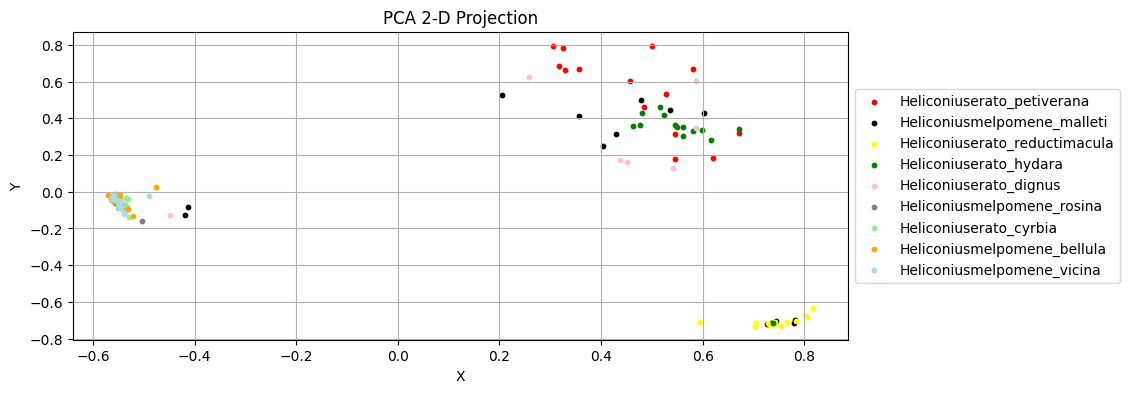

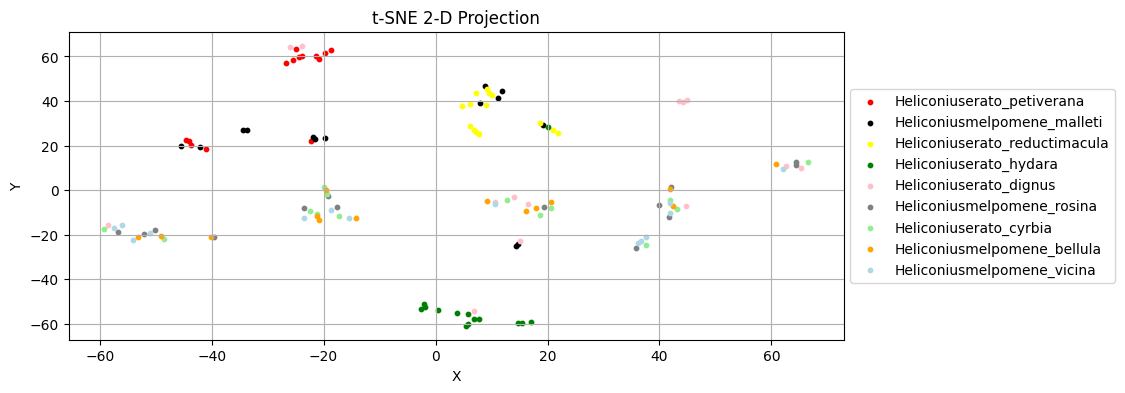

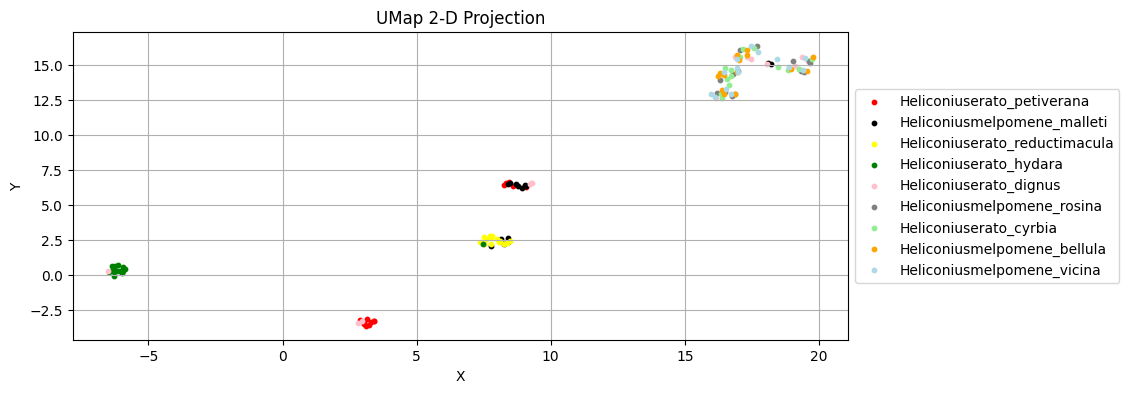

In [39]:
plot_embeddings(test_dataset, runner.model, "arcface", "cuda:0")

In [50]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns

def get_confusion_matrix(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    accuracy_list = []
    preds = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            logits = encoder(x, y)
            preds += list(logits.argmax(1).numpy())
            accuracy = (logits.argmax(1) == y).float().mean().detach().cpu()
            accuracy_list.append(accuracy)
            labels += list(y.numpy())
    embeddings = np.concatenate(embeddings)
    gt = labels
    accuracy_list = [x.item() for x in accuracy_list]
    preds = [class_names[preds[i]] for i in range(len(preds))]
    gt = [class_names[gt[i]] for i in range(len(gt))]
    '''
    cm = confusion_matrix(gt, preds, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_names)
    disp.plot()

    plt.show()
    '''
    cm = confusion_matrix(gt, preds)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(cmn, annot=True,  xticklabels= class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion matrix.png', dpi = fig.dpi)
    plt.show(block=False)


In [66]:
get_confusion_matrix(test_dataset, runner.model, "arcface")

0 /content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_butterfly/classification-experiments/test/Heliconiuserato_petiverana/Heliconiuserato_petiverana_0002.jpg
4 
/content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_butterfly/classification-experiments/test/Heliconiuserato_cyrbia/Heliconiuserato_cyrbia_0149.jpg
2 /content/drive/MyDrive/butterfly_jiggins_dataset/jiggins_dataset_butterfly/classification-experiments/test/Heliconiuserato_lativitta/Heliconiuserato_lativitta_0013.jpg

KeyError: ignored

In [ ]:
species_dict = dict((i,j) for i,j in enumerate(species2index))
species = list(species_dict.items())
class_names = [species[i][1] for i in range(len(species))]
class_names

['Heliconiuserato_petiverana',
 'Heliconiuserato_reductimacula',
 'Heliconiusmelpomene_malleti',
 'Heliconiuserato_hydara',
 'Heliconiusmelpomene_vicina',
 'Heliconiuserato_cyrbia',
 'Heliconiuserato_dignus',
 'Heliconiusmelpomene_rosina',
 'Heliconiusmelpomene_cythera',
 'Heliconiusmelpomene_bellula',
 'Heliconiusmelpomene_nanna',
 'Heliconiusmelpomene_plesseni',
 'Heliconiuserato_lativitta',
 'Heliconiuserato_venus',
 'Heliconiuserato_notabilis',
 'Heliconiusmelpomene_vulcanus',
 'Heliconiusmelpomene_melpomene',
 'Heliconiuserato_phyllis']

In [42]:
class_names = [mimic_list[i][0] for i in range(len(mimic_list))]
class_names = [0,1,2,3,4,5,6,7,8]
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
cnames = [elem.split("Heliconius")[1] for elem in class_names]
cnames

['melpomene_vicina',
 'erato_hydara',
 'erato_reductimacula',
 'melpomene_bellula',
 'melpomene_malleti',
 'erato_petiverana',
 'erato_cyrbia',
 'erato_dignus',
 'melpomene_rosina',
 'erato_notabilis',
 'erato_lativitta',
 'melpomene_vulcanus',
 'erato_venus',
 'melpomene_plesseni',
 'melpomene_cythera',
 'melpomene_melpomene',
 'melpomene_nanna',
 'erato_phyllis']

In [ ]:
species2index

{'Heliconiusmelpomene_vicina': 0,
 'Heliconiuserato_hydara': 1,
 'Heliconiuserato_reductimacula': 2,
 'Heliconiusmelpomene_bellula': 3,
 'Heliconiusmelpomene_malleti': 4,
 'Heliconiuserato_petiverana': 5,
 'Heliconiuserato_cyrbia': 6,
 'Heliconiusmelpomene_ecuadorensis': 7,
 'Heliconiuserato_dignus': 8,
 'Heliconiusmelpomene_rosina': 9,
 'Heliconiuserato_notabilis': 10,
 'Heliconius_melpomene': 11,
 'Heliconiuserato_lativitta': 12,
 'Heliconiusmelpomene_vulcanus': 13,
 'Heliconiuserato_venus': 14,
 'Heliconiusmelpomene_plesseni': 15,
 'Heliconiusmelpomene_cythera': 16,
 'Heliconiusmelpomene_melpomene': 17,
 'Heliconiusmelpomene_nanna': 18,
 'Heliconius_erato': 19,
 'Heliconiuserato_etylus': 20,
 'Heliconiuserato_phyllis': 21}

## Sub-center ArcFace

In [ ]:
logdir = "logs/arcface"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = EncoderWithHead(
    encoder,
    SubCenterArcFace(
        128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25, k=3
    )
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
)

[2020-12-29 09:34:28,529] 
1/20 * Epoch 1 (train): accuracy=0.0078 | loss=2.7692
1/20 * Epoch 1 (valid): accuracy=0.0954 | loss=2.3841
[2020-12-29 09:34:51,550] 
2/20 * Epoch 2 (train): accuracy=0.4291 | loss=1.9578
2/20 * Epoch 2 (valid): accuracy=0.6343 | loss=1.6349
[2020-12-29 09:35:14,535] 
3/20 * Epoch 3 (train): accuracy=0.6968 | loss=1.4528
3/20 * Epoch 3 (valid): accuracy=0.7432 | loss=1.3271
[2020-12-29 09:35:37,893] 
4/20 * Epoch 4 (train): accuracy=0.7651 | loss=1.2232
4/20 * Epoch 4 (valid): accuracy=0.7788 | loss=1.1737
[2020-12-29 09:36:00,825] 
5/20 * Epoch 5 (train): accuracy=0.8003 | loss=1.0987
5/20 * Epoch 5 (valid): accuracy=0.7956 | loss=1.0819
[2020-12-29 09:36:23,716] 
6/20 * Epoch 6 (train): accuracy=0.8225 | loss=1.0130
6/20 * Epoch 6 (valid): accuracy=0.8127 | loss=1.0171
[2020-12-29 09:36:47,180] 
7/20 * Epoch 7 (train): accuracy=0.8368 | loss=0.9547
7/20 * Epoch 7 (valid): accuracy=0.8262 | loss=0.9680
[2020-12-29 09:37:11,070] 
8/20 * Epoch 8 (train): accu

In [ ]:
save_embeddings(vis_dataset, encoder, "subcenterarcface", "cuda:0")

NameError: name 'vis_dataset' is not defined

In [ ]:
# %tensorboard --logdir subcenterarcface

## ArcMarginProduct

In [ ]:
logdir = "logs/arcmarginproduct"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = nn.Sequential(
    encoder,
    ArcMarginProduct(128, n_classes),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy01",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
    callbacks=[dl.AccuracyCallback(num_classes=n_classes)],
)

[2020-12-29 09:50:26,059] 
1/20 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/20 * Epoch 1 (train): accuracy01=0.2247 | accuracy03=0.4644 | accuracy05=0.6455 | loss=2.2725
1/20 * Epoch 1 (valid): accuracy01=0.3332 | accuracy03=0.6119 | accuracy05=0.7615 | loss=2.2432
[2020-12-29 09:50:48,993] 
2/20 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/20 * Epoch 2 (train): accuracy01=0.4592 | accuracy03=0.7279 | accuracy05=0.8461 | loss=2.2085
2/20 * Epoch 2 (valid): accuracy01=0.5780 | accuracy03=0.8190 | accuracy05=0.9030 | loss=2.1698
[2020-12-29 09:51:13,302] 
3/20 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/20 * Epoch 3 (train): accuracy01=0.6635 | accuracy03=0.8655 | accuracy05=0.9251 | loss=2.1228
3/20 * Epoch 3 (valid): accuracy01=0.7279 | accuracy03=0.8974 | accuracy05=0.9504 | loss=2.0717
[2020-12-29 09:51:37,426] 
4/20 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/20 * Epoch 4 (train): accuracy01=0.7800 | accuracy03=0.9256 | accuracy05=0.9680 | loss=2.0183
4/20 * Epoch

In [ ]:
save_embeddings(vis_dataset, encoder, "arcmarginproduct", "cuda:0")

In [ ]:
# %tensorboard --logdir arcmarginproduct

## Classification

In [ ]:
logdir = "logs/classification"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = nn.Sequential(
    encoder,
    nn.Linear(128, n_classes),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy01",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
    callbacks=[dl.AccuracyCallback(num_classes=n_classes)],
)

[2020-12-29 10:07:35,042] 
1/20 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/20 * Epoch 1 (train): accuracy01=0.4906 | accuracy03=0.7066 | accuracy05=0.8241 | loss=1.9374
1/20 * Epoch 1 (valid): accuracy01=0.7758 | accuracy03=0.9270 | accuracy05=0.9687 | loss=1.4426
[2020-12-29 10:08:00,519] 
2/20 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/20 * Epoch 2 (train): accuracy01=0.8432 | accuracy03=0.9593 | accuracy05=0.9857 | loss=1.0912
2/20 * Epoch 2 (valid): accuracy01=0.8679 | accuracy03=0.9712 | accuracy05=0.9924 | loss=0.7731
[2020-12-29 10:08:26,828] 
3/20 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/20 * Epoch 3 (train): accuracy01=0.8949 | accuracy03=0.9826 | accuracy05=0.9953 | loss=0.6349
3/20 * Epoch 3 (valid): accuracy01=0.8946 | accuracy03=0.9773 | accuracy05=0.9931 | loss=0.5257
[2020-12-29 10:08:52,764] 
4/20 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/20 * Epoch 4 (train): accuracy01=0.9138 | accuracy03=0.9869 | accuracy05=0.9964 | loss=0.4463
4/20 * Epoch

In [ ]:
save_embeddings(vis_dataset, encoder, "classification", "cuda:0")

In [ ]:
# %tensorboard --logdir classification